In [1]:
import numpy as np
import choix
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import os
import sys

In [2]:
from splitting_dataset import create_dataset, index_data_by_reference, train_val_test_split, train_val_test_kfold_split
from penalty import penalty

In [3]:
base_path = '../../data/similarity/'
multi_df, single_dfs, size_map, item_reference_id_map = create_dataset(base_path)

In [4]:
datasets = index_data_by_reference(multi_df, single_dfs, item_reference_id_map)
n_items = 99

In [5]:
alphas = np.logspace(-5, 4, 20)
sizes = [2, 4, 8, 12, 16]
val_loglikelihoods = dict()
test_loglikelihoods = dict()
for alpha in alphas:
    results = {'val': dict(), 'test': dict()}
    for reference, data in datasets.items():
        training_data, validation_data, test_data = train_val_test_split(data, 0.1)
        params = choix.lsr_top1(n_items, training_data, alpha=alpha)
        val_ll = dict()
        test_ll = dict()
        for size in sizes:
            val_ll[size] = choix.log_likelihood_top1(validation_data[size], params)/len(validation_data[size])
            test_ll[size] = choix.log_likelihood_top1(test_data[size], params)/len(test_data[size])
        results['val'][reference] = val_ll
        results['test'][reference] = test_ll
    for size in sizes:
        if size not in val_loglikelihoods:
            val_loglikelihoods[size] = []
        val_loglikelihoods[size].append(np.mean([result[size] for result in results['val'].values()]))
        if size not in test_loglikelihoods:
            test_loglikelihoods[size] = []
        test_loglikelihoods[size].append(np.mean([result[size] for result in results['test'].values()]))


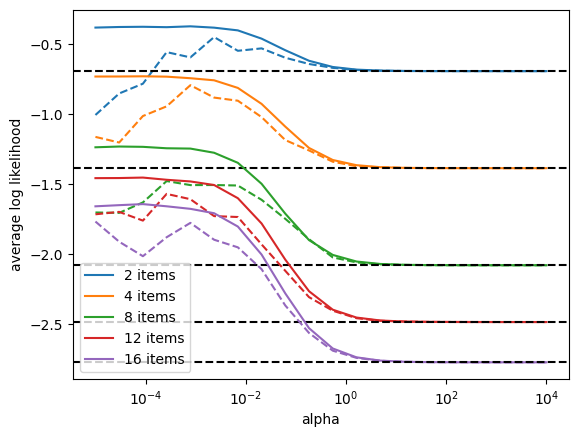

In [6]:

plt.figure()
# get color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, size in enumerate(sizes):
    plt.plot(alphas, val_loglikelihoods[size], label=f'{size} items', color=colors[i])
    plt.plot(alphas, test_loglikelihoods[size], color=colors[i], linestyle='dashed')
    # plot a horizontal line at -log(size)
    plt.axhline(-np.log(size), color='black', linestyle='dashed')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('average log likelihood')
plt.legend()
plt.show()

In [ ]:
k = 10 # number of folds
alphas = np.logspace(-5, 4, 20)
sizes = [2, 4, 8, 12, 16]
split_size = dict()
results = np.zeros((2, 2, len(sizes), len(alphas)))# first dimension is accuracy and loglikelihood, second is validation and test
for reference, dataset in datasets.items():
    # k-fold cross validation data preparation
    for i in range(k):
        training_data, validation_data, test_data = train_val_test_kfold_split(dataset, i, k)
        for j, alpha in enumerate(alphas):
            params = choix.lsr_top1(n_items, training_data, alpha=alpha)        # fitting the model to the data
            for l, size in enumerate(sizes):
                val_ll = choix.log_likelihood_top1(validation_data[size], params) / len(validation_data[size])
                test_ll = choix.log_likelihood_top1(test_data[size], params) / len(test_data[size])
                results[0, 0, l, j] += penalty(params, validation_data[size])
                results[0, 1, l, j] += penalty(params, test_data[size])
                results[1, 0, l, j] += val_ll
                results[1, 1, l, j] += test_ll
results /= (k*len(multi_df['reference'].unique()))


In [ ]:
plt.figure()
# get color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, size in enumerate(sizes):
    plt.plot(alphas, results[1, 0, i], label=f'{size} items', color=colors[i])
    plt.plot(alphas, results[1, 1, i], color=colors[i], linestyle='dashed')
    # plot a horizontal line at -log(size)
    plt.axhline(-np.log(size), color='black', linestyle='dashed')
plt.xscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('average log likelihood')
plt.legend()
plt.show()

In [ ]:
plt.figure()
# get color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
for i, size in enumerate(sizes):
    plt.plot(alphas, results[0, 0, i], label=f'{size} items', color=colors[i])
    plt.plot(alphas, results[0, 1, i], color=colors[i], linestyle='dashed')
plt.xscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('average penalty')
plt.legend()
plt.show()